In [20]:
from collections import Counter
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import CuDNNGRU, Input, Dense, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.losses import sparse_categorical_crossentropy
import keras

In [21]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [23]:
def load_data(path):
    with open(path, "r", encoding='utf-8') as f:
        data = f.read()
    return data.split('\n')

In [24]:
english_sentences = load_data('data/small_vocab_en')
french_sentences = load_data('data/small_vocab_fr')

## Vocabulary

In [26]:
english_words_counter = Counter([word for sentence in english_sentences for word in sentence.split()])

french_words_counter = Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')

print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


## Tokenize

In [32]:
def tokenize(x):

    x_tk = Tokenizer()
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']

text_tokenized, text_tokenizer = tokenize(text_sentences)

print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


## Padding 

In [33]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
        
    return pad_sequences(x, maxlen=length, padding='post')

test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


## Preprocess Pipeline

In [34]:
def preprocess(x, y):

    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


## Map token ids back to text

In [35]:
def logits_to_text(logits, tokenizer):

    idx_to_words = {id: word for word, id in tokenizer.word_index.items()}
    idx_to_words[0] = '<PAD>'

    return ' '.join([idx_to_words[prediction] for prediction in np.argmax(logits, 1)])

## Prepare train, test set in 2D and 3D for model input 

In [41]:
x_train_2d= pad(preproc_english_sentences, max_french_sequence_length)
x_train_2d.shape

(137861, 21)

In [42]:
x_train_3d= x_2d.reshape((-1, preproc_french_sentences.shape[-2], 1))
x_train_3d.shape

(137861, 21, 1)

In [43]:
y_train=preproc_french_sentences

## Model 1: RNN 
- 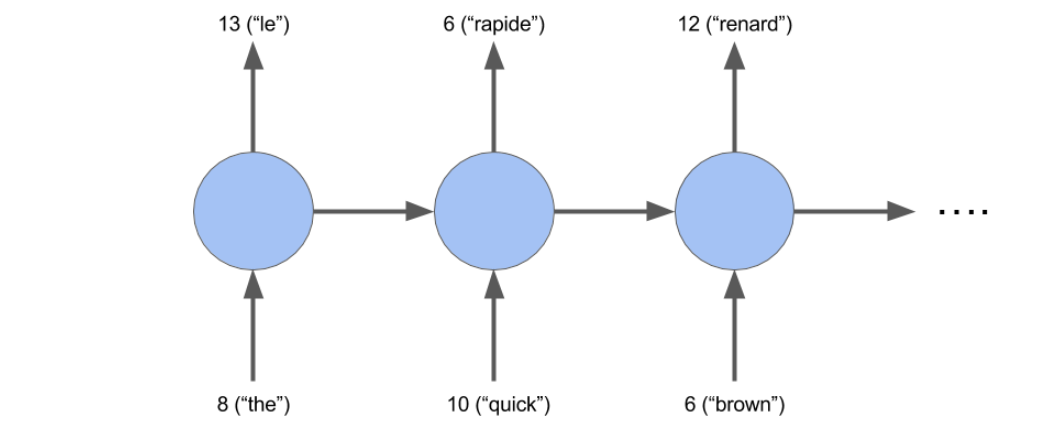

In [47]:
def simple_model(x_input, english_vocab_size, french_vocab_size):

    input_seq = Input(shape=x_input.shape[1:]) 

    rnn = CuDNNGRU(units=english_vocab_size, return_sequences=True)(input_seq)
    
    logits = Dense(units=french_vocab_size, activation='softmax')(rnn) 
    
    model = Model(inputs=input_seq, outputs=logits)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    return model

simple_rnn_model = simple_model(
    x_train_3d,english_vocab_size,
    french_vocab_size)

simple_rnn_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 21, 199)           120594    
_________________________________________________________________
dense_3 (Dense)              (None, 21, 344)           68800     
Total params: 189,394
Trainable params: 189,394
Non-trainable params: 0
_________________________________________________________________


In [48]:
simple_rnn_model.fit(x_train_3d, y_train, batch_size=512, epochs=5, validation_split=0.2)

print('---------------')
print(logits_to_text(simple_rnn_model.predict(x_train_3d[:1])[0], french_tokenizer))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 110288 samples, validate on 27573 samples
Epoch 1/5
110288/110288 [==============================] - 3s 30us/step - loss: 2.2818 - acc: 0.5121 - val_loss: nan - val_acc: 0.5889
Epoch 2/5
110288/110288 [==============================] - 3s 26us/step - loss: 1.4931 - acc: 0.6034 - val_loss: nan - val_acc: 0.6234
Epoch 3/5
110288/110288 [==============================] - 3s 26us/step - loss: 1.2930 - acc: 0.6364 - val_loss: nan - val_acc: 0.6479
Epoch 4/5
110288/110288 [==============================] - 3s 26us/step - loss: 1.1730 - acc: 0.6584 - val_loss: nan - val_acc: 0.6672
Epoch 5/5
110288/110288 [==============================] - 3s 26us/step - loss: 1.1008 - acc: 0.6677 - val_loss: nan - val_acc: 0.6708
---------------
new jersey est parfois calme en mois de mai il il est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


## Model 2: Embedding 
- 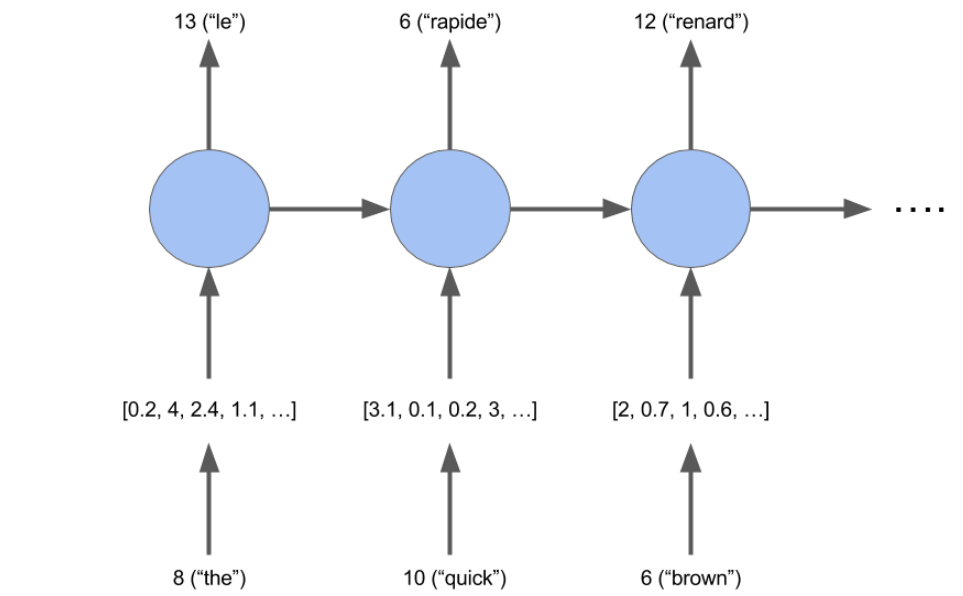


In [ ]:
def embed_model(x_input, english_vocab_size, french_vocab_size):

    embedding_size = 512
    rnn_cells = 512

    input_seq = Input(shape=x_input.shape[1:]) 
    
    embedded_seq = Embedding(input_dim = english_vocab_size, 
                         output_dim = embedding_size,
                         input_length=x_input.shape[1])(input_seq)
    
    rnn = CuDNNGRU(units=rnn_cells, return_sequences=True)(embedded_seq)
    logits = Dense(units=french_vocab_size, activation='softmax')(rnn) 
    
    model = Model(inputs=input_seq, outputs=logits)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    return model  

embeding_rnn_model = embed_model(x_input = x_train_2d,
                              english_vocab_size = english_vocab_size,
                              french_vocab_size = french_vocab_size)
embeding_rnn_model.summary()

In [85]:
# Train the neural network 
embeding_rnn_model.fit(x_train_2d, y_train, batch_size=512, epochs=10, validation_split=0.2)

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 7s 59us/step - loss: 1.6972 - acc: 0.6459 - val_loss: nan - val_acc: 0.8122
Epoch 2/10
110288/110288 [==============================] - 6s 51us/step - loss: 0.4723 - acc: 0.8560 - val_loss: nan - val_acc: 0.8868
Epoch 3/10
110288/110288 [==============================] - 6s 51us/step - loss: 0.3128 - acc: 0.8987 - val_loss: nan - val_acc: 0.9066
Epoch 4/10
110288/110288 [==============================] - 6s 53us/step - loss: 0.2557 - acc: 0.9152 - val_loss: nan - val_acc: 0.9219
Epoch 5/10
110288/110288 [==============================] - 6s 51us/step - loss: 0.2234 - acc: 0.9246 - val_loss: nan - val_acc: 0.9264
Epoch 6/10
110288/110288 [==============================] - 6s 51us/step - loss: 0.2052 - acc: 0.9294 - val_loss: nan - val_acc: 0.9291
Epoch 7/10
110288/110288 [==============================] - 6s 51us/step - loss: 0.1924 - acc: 0.9327 - val_loss: nan - val_acc: 0.93

In [88]:
print(logits_to_text(embeding_rnn_model.predict(x_train_2d[:1])[0], french_tokenizer))

new jersey est parfois calme en l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


## Model 3: Bidirectional RNNs
- 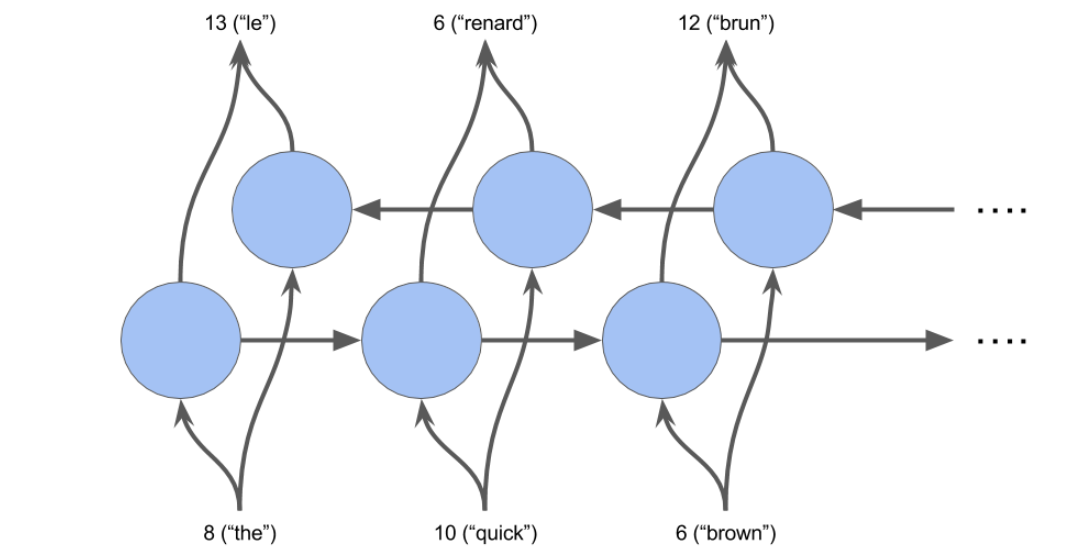

In [94]:
def bd_model(x_input, english_vocab_size, french_vocab_size):

    embedding_size = 512
    rnn_cells = 512

    input_seq = Input(shape=x_input.shape[1:]) 
    
    bdrnn = Bidirectional(CuDNNGRU(units=rnn_cells, return_sequences=True))(input_seq)
    logits = Dense(units=french_vocab_size, activation='softmax')(bdrnn) 
    
    model = Model(inputs=input_seq, outputs=logits)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    return model  

bidirectional_model = bd_model(x_train_3d,english_vocab_size,french_vocab_size)

bidirectional_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 1024)          1582080   
_________________________________________________________________
dense_7 (Dense)              (None, 21, 344)           352600    
Total params: 1,934,680
Trainable params: 1,934,680
Non-trainable params: 0
_________________________________________________________________


In [95]:
bidirectional_model.fit(x_train_3d, y_train, batch_size=1024, epochs=10, validation_split=0.2)
print('---------------')
print(logits_to_text(bidirectional_model.predict(x_train_3d[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 8s 74us/step - loss: 1.8522 - acc: 0.5717 - val_loss: nan - val_acc: 0.6266
Epoch 2/10
110288/110288 [==============================] - 6s 59us/step - loss: 1.2338 - acc: 0.6463 - val_loss: nan - val_acc: 0.6629
Epoch 3/10
110288/110288 [==============================] - 6s 58us/step - loss: 1.0798 - acc: 0.6779 - val_loss: nan - val_acc: 0.6876
Epoch 4/10
110288/110288 [==============================] - 6s 58us/step - loss: 0.9777 - acc: 0.6961 - val_loss: nan - val_acc: 0.7067
Epoch 5/10
110288/110288 [==============================] - 6s 58us/step - loss: 0.9107 - acc: 0.7062 - val_loss: nan - val_acc: 0.7129
Epoch 6/10
110288/110288 [==============================] - 6s 58us/step - loss: 0.8673 - acc: 0.7136 - val_loss: nan - val_acc: 0.7211
Epoch 7/10
110288/110288 [==============================] - 6s 58us/step - loss: 0.8243 - acc: 0.7214 - val_loss: nan - val_acc: 0.72

## Model 4: Encoder-Decoder 

In [100]:
from keras.layers import CuDNNLSTM

def encdec_model(x_input, output_sequence_length, english_vocab_size, french_vocab_size):
    
    embedding_size = 512
    rnn_cells = 512

    encoder_input_seq = Input(shape=x_input.shape[1:]) 
    encoder = CuDNNLSTM(units=rnn_cells, return_state=True,return_sequences=False)
    encoder_outputs, state_h, state_c = encoder(encoder_input_seq)
    encoder_states = [state_h, state_c]

    decoder_input_seq = RepeatVector(output_sequence_length)(encoder_outputs)

    decoder_lstm = CuDNNLSTM(units=rnn_cells, return_sequences=True, return_state=True)
    decoder_outputs, _, _ =decoder_lstm(decoder_input_seq, initial_state=encoder_states)
    
    decoder_dense = Dense(units=french_vocab_size, activation='softmax')    
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model(inputs=encoder_input_seq, outputs=decoder_outputs)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    
    return model   

en_decoder_rnn_model = encdec_model(x_input = x_train_3d,
                                output_sequence_length = max_french_sequence_length,
                                english_vocab_size = english_vocab_size,
                                french_vocab_size = french_vocab_size)
    
en_decoder_rnn_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 21, 1)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)        [(None, 512), (None, 1054720     input_10[0][0]                   
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 21, 512)      0           cu_dnnlstm_3[0][0]               
__________________________________________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)        [(None, 21, 512), (N 2101248     repeat_vector_2[0][0]            
                                                                 cu_dnnlstm_3[0][1]         

In [102]:
en_decoder_rnn_model.fit(x_train_3d, y_train, batch_size=1024, epochs=10, validation_split=0.2)
print(logits_to_text(en_decoder_rnn_model.predict(x_train_3d[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 11s 97us/step - loss: 2.3038 - acc: 0.5090 - val_loss: nan - val_acc: 0.5539
Epoch 2/10
110288/110288 [==============================] - 8s 77us/step - loss: 1.5801 - acc: 0.5803 - val_loss: nan - val_acc: 0.6056
Epoch 3/10
110288/110288 [==============================] - 8s 75us/step - loss: 1.3649 - acc: 0.6170 - val_loss: nan - val_acc: 0.6287
Epoch 4/10
110288/110288 [==============================] - 8s 75us/step - loss: 1.2517 - acc: 0.6338 - val_loss: nan - val_acc: 0.6398
Epoch 5/10
110288/110288 [==============================] - 8s 75us/step - loss: 1.2087 - acc: 0.6381 - val_loss: nan - val_acc: 0.6500
Epoch 6/10
110288/110288 [==============================] - 8s 76us/step - loss: 1.1269 - acc: 0.6520 - val_loss: nan - val_acc: 0.6563
Epoch 7/10
110288/110288 [==============================] - 8s 76us/step - loss: 1.0813 - acc: 0.6615 - val_loss: nan - val_acc: 0.6

## Model 5 embedding and bidirectional

In [107]:
def model_final(x_input, english_vocab_size, french_vocab_size):

    embedding_size = 512
    rnn_cells = 512
    
    input_seq = Input(shape=x_input.shape[1:])     
    embedded_seq = Embedding(input_dim = english_vocab_size, 
                         output_dim = embedding_size,
                         input_length=x_input.shape[1])(input_seq)    
    bdrnn = Bidirectional(CuDNNLSTM(units=rnn_cells, return_sequences=True))(embedded_seq)
    dense = Dense(units=french_vocab_size, activation='softmax')
    logits = dense(bdrnn) 
    
    model = Model(inputs=input_seq, outputs=logits)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    return model  

final_model = model_final(x_train_2d,english_vocab_size,french_vocab_size)

final_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 21)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 21, 512)           101888    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 21, 1024)          4202496   
_________________________________________________________________
dense_10 (Dense)             (None, 21, 344)           352600    
Total params: 4,656,984
Trainable params: 4,656,984
Non-trainable params: 0
_________________________________________________________________


In [111]:
final_model.fit(x_train_2d, y_train, batch_size=1024, epochs=10, validation_split=0.2)
print('---------------')
print(logits_to_text(final_model.predict(x_train_2d[:1])[0], french_tokenizer))

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 11s 97us/step - loss: 0.0871 - acc: 0.9740 - val_loss: nan - val_acc: 0.9713
Epoch 2/10
110288/110288 [==============================] - 11s 96us/step - loss: 0.0790 - acc: 0.9763 - val_loss: nan - val_acc: 0.9719
Epoch 3/10
110288/110288 [==============================] - 11s 96us/step - loss: 0.0742 - acc: 0.9775 - val_loss: nan - val_acc: 0.9745
Epoch 4/10
110288/110288 [==============================] - 11s 96us/step - loss: 0.0674 - acc: 0.9796 - val_loss: nan - val_acc: 0.9770
Epoch 5/10
110288/110288 [==============================] - 11s 96us/step - loss: 0.0617 - acc: 0.9814 - val_loss: nan - val_acc: 0.9770
Epoch 6/10
110288/110288 [==============================] - 11s 96us/step - loss: 0.0591 - acc: 0.9819 - val_loss: nan - val_acc: 0.9779
Epoch 7/10
110288/110288 [==============================] - 11s 96us/step - loss: 0.0531 - acc: 0.9838 - val_loss: nan - val_ac

## Test with custom sentence

In [194]:
test_sentence = 'i visit paris in may it was beautiful and relaxing'
sentence = [english_tokenizer.word_index.get(word) for word in test_sentence.split()]
sentence

[96, 108, 18, 2, 40, 3, 104, 53, 7, 66]

In [192]:
sentence = pad_sequences([sentence], maxlen=21, padding='post')
sentence

array([[ 96, 108,  18,   2,  40,   3, 104,  53,   7,  66,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]])

In [193]:
print(logits_to_text(final_model.predict(sentences)[0], french_tokenizer))

je est paris au mois de mai mais il est relaxant en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
